<a href="https://colab.research.google.com/github/rskool/reversal_learning_tutorial/blob/main/RL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello!
Welcome to the wonderful world of behavioural modelling.

In this tutorial, you will get a taste for how the use of computational models may help us understand behaviour. We aim to give you a flavour of the mechanics and different steps involved. Here we focus on a very basic learning model: the **reinforcement learning (RL)** model. In this tutorial, you will learn how you can start to use an RL model to understand your participants’ behaviour. Rather than purporting to be complete, we will hand you the tools to start thinking and reading for yourself.

---
 # Getting Started
Before completing this tutorial, please make sure you __have completed the gambling task yourself.__ You can find it here: (add link)

Then, run the setup code below (either by pressing the "Run Cell" button or by hitting Command/CTRL + Enter.

In [ ]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Utility and plotting Functions

def softmax(beta=3):
    va = np.arange(0,1.02,0.02)
    vb = 1 - va
    x = 0.02

    pa = np.exp(beta*va)/(np.exp(beta*va)+np.exp(beta*vb))
    tmp = np.random.rand(51)< pa*(1+x)
    data = tmp
    x_axis = va-vb
    return pa, data, x_axis

def getVolatil(subj):
  volatil = ['high', 'low']
  taskV = np.mod(subj,2);
  return volatil[taskV]

def getFbProb(subj):
  
  taskVersion = np.mod(subj,2)

  if taskVersion==0:
    # even: high volatility
    block1 = 0.7*np.ones(17)
    block2 = 0.3*np.ones(15)
    block3 = 0.7*np.ones(19)
    block4 = 0.3*np.ones(18)
    block5 = 0.7*np.ones(15)
    block6 = 0.3*np.ones(17)
    block7 = 0.7*np.ones(19)
    block8 = 0.3*np.ones(15)
    fbProb = np.concatenate((block1, block2, block3, block4, block5, block6, block7, block8),axis=None)
  elif taskVersion==1:
    # uneven: low volatility
    block1 = 0.7*np.ones(35)
    block2 = 0.3*np.ones(30)
    block3 = 0.7*np.ones(35)
    block4 = 0.3*np.ones(35)
    fbProb = np.concatenate((block1, block2, block3, block4),axis=None)

  return fbProb

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def genFb(subj):
  fbProb = getFbProb(subj)
  feedback = np.empty((0,2), int)
 

  for trial in range(len(fbProb)):
    cointoss = int(np.random.rand(1)<=fbProb[trial])
    feedback = np.append(feedback, cointoss, axis=None)
  
  feedback = np.append(feedback[:,None], 1-feedback[:,None],axis=1)
  return feedback


def revlPlotData(subj,subjData,plotFit=False):
  
  choice = subjData['choice']
  x_axis=np.arange(1,136,1)

  fig, ax = plt.subplots()
  ax.plot(x_axis,getFbProb(subj),'k',label="p(reward|blue)")
  ax.plot(x_axis,choice,'k',marker='*',linestyle = 'None',label="Choice")
  ax.plot(x_axis,smooth(choice,5),'r:',label="Smoothed choice")

  if plotFit:
    ax.plot(x_axis,simData['pfit'],'g',label="est p(reward|blue)")

  ax.set_title('Subject '+str(subj)+', '+ getVolatil(subj) +' volatility')
  ax.set_ylabel('p(Reward|Blue)')
  ax.set_xlabel('Trial')
  ax.legend(loc='upper right',bbox_to_anchor=(1.5, 0.5))

def revlPlotAll(subj,subjDataAll,plotFit=False):
  x_axis=np.arange(1,136,1)
  fig, (ax1, ax2) = plt.subplots(nrows = 2)

  unevenIdx = np.mod(subj,2)

  ax1.plot(x_axis,getFbProb(1),'k:',label="p(reward|blue)")
  ax1.plot(x_axis, np.mean(subjDataAll['choice'][:,unevenIdx==1],axis=1),'k',label="Mean choice")
  if plotFit: 
    ax1.plot(x_axis, np.mean(subjDataAll['pfit'][:,unevenIdx==1],axis=1),'b',label="p(choose blue)")
  
  ax1.set_title('MEAN data, Low volatility')

  ax2.plot(x_axis,getFbProb(2),'k:',label="p(reward|blue)")
  ax2.plot(x_axis, np.mean(subjDataAll['choice'][:,unevenIdx==0],axis=1),'k',label="Mean choice")
  if plotFit: 
      ax2.plot(x_axis, np.mean(subjDataAll['pfit'][:,unevenIdx==0],axis=1),'b',label="p(choose blue)")
  ax2.set_title('MEAN data, High volatility')
  ax2.legend(loc='upper right',bbox_to_anchor=(1.5, 0.5))

def plotMarg(lik,fitSettings):
             
    stepAlpha = (fitSettings['bounds'][0][1]-fitSettings['bounds'][0][0])/fitSettings['nBin'][0]
    alphaVals = np.arange(fitSettings['bounds'][0][0],fitSettings['bounds'][0][1],stepAlpha)
    stepBeta = (fitSettings['bounds'][1][1]-fitSettings['bounds'][1][0])/fitSettings['nBin'][1]
    betaVals = np.arange(fitSettings['bounds'][1][0],fitSettings['bounds'][1][1],stepBeta)              

    marglik = calcMarglik(lik)
    fig, (ax1, ax2) = plt.subplots(ncols = 2)

    ax1.plot(alphaVals,marglik[:,1],'k')
    ax1.set_title('marginal distribution, alpha')
    ax1.set_ylabel('p(data|m)')
    ax1.set_xlabel('alpha')

    ax2.plot(betaVals,marglik[:,0],'k')
    ax2.set_title('marginal distribution, beta')
    ax2.set_ylabel('p(data|m)')
    ax2.set_xlabel('beta')

def calcMarglik(lik):
    marglik = np.zeros((),int)
    for i in range(2):
        tmp = np.sum(lik,axis=i)
        print(tmp/np.sum(tmp))
        #marglik[:,i] = tmp/np.sum(tmp) # this should be two arrays
    return marglik

def revlPlotSimSingle(subj, simData, simpars,plotFit=False):

  x_axis=np.arange(1,136,1)
  fig, ax = plt.subplots()
    
  ax.plot(x_axis,getFbProb(subj),'k',label="p(reward|blue)")
  ax.plot(x_axis,simData['PP'][:,0],'b', label="p(choose blue)")
  ax.plot(x_axis, simData['VV'][:,0], 'b:', label="value(blue)")
  ax.plot(x_axis, simData['VV'][:,1], 'r:', label="value(orange)")
  ax.plot(x_axis, simData['choice'],'k',marker='*',linestyle = 'None',label="Choice")

  if plotFit:
      ax.plot(x_axis,simData['pfit'][:],'g', label="est p(choose blue)")

  ax.legend(loc='upper right',bbox_to_anchor=(1.5, 0.5))
  ax.set_ylabel('Probability')
  ax.set_xlabel('Trial')
  ax.set_title('Subject '+ str(subj) +' simulated data, alpha = '+ str(simpars['alpha']) +', beta = '+str(simpars['beta']))

def revlPlotMean(subj, simData, simPars):
  x_axis=np.arange(1,136,1)
  fig, (ax1, ax2) = plt.subplots(nrows = 2)

  unevenIdx = np.mod(subj,2)

  ax1.plot(x_axis,getFbProb(1),'k:',label="p(reward|blue)")
  ax1.plot(x_axis, np.mean(simData['choice'][:,unevenIdx==1],axis=1),'k',label="Mean choice")
  ax1.plot(x_axis, np.mean(simData['PP'][:,unevenIdx==1],axis=1),'b',label="p(choose blue)")
  ax1.plot(x_axis, np.mean(simData['Vorange'][:,unevenIdx==1],axis=1),'r:',label="value(orange)")
  ax1.plot(x_axis, np.mean(simData['Vblue'][:,unevenIdx==1],axis=1),'b:',label="value(blue)")
  ax1.set_title('MEAN data, Low volatility, alpha = '+ str(simPars['alpha']) +', beta = '+str(simPars['beta']))

  ax2.plot(x_axis,getFbProb(2),'k:',label="p(reward|blue)")
  ax2.plot(x_axis, np.mean(simData['choice'][:,unevenIdx==0],axis=1),'k',label="Mean choice")
  ax2.plot(x_axis, np.mean(simData['PP'][:,unevenIdx==0],axis=1),'b',label="p(choose blue)")
  ax2.plot(x_axis, np.mean(simData['Vorange'][:,unevenIdx==0],axis=1),'r:',label="value(orange)")
  ax2.plot(x_axis, np.mean(simData['Vblue'][:,unevenIdx==0],axis=1),'b:',label="value(blue)")
  ax2.set_title('MEAN data, High volatility, alpha = '+ str(simPars['alpha']) +', beta = '+str(simPars['beta']))
  ax2.legend(loc='upper right',bbox_to_anchor=(1.5, 0.5))

def plotMeanScore(subj, simDataAll):
  fig, ax = plt.subplots()

  unevenIdx = np.mod(subj,2)

  ax.bar([1],
       height=[np.mean(simDataAll['score'][:,unevenIdx==0])],
       yerr=[np.std(simDataAll['score'][:,unevenIdx==0])],# error bar
       capsize=12, 
       width=0.4,    # bar width
       color='b',  # face color transparent
       edgecolor='b',
       alpha=0.8)

  ax.scatter(1 + np.random.random(simDataAll['score'][:,unevenIdx==0].size) * 0.2 - 0.2 / 2, simDataAll['score'][:,unevenIdx==0], color='r')

  ax.bar([2],
       height=[np.mean(simDataAll['score'][:,unevenIdx==1])],
       yerr=[np.std(simDataAll['score'][:,unevenIdx==1])],# error bar
       capsize=12, 
       width=0.4,    # bar width
       color='b',  # face color transparent
       edgecolor='b',
       alpha=0.8)

  ax.scatter(2 + np.random.random(simDataAll['score'][:,unevenIdx==1].size) * 0.2 - 0.2 / 2, simDataAll['score'][:,unevenIdx==1], color='r') 

  plt.xticks(np.arange(1,3), ('High', 'Low'))
  ax.set_ylabel('p(correct))')
  ax.set_xlabel('volatility')
  ax.set_title('correct choice')

  plt.show()

def getParamEst(lik,fitSettings):
    maxCoord = np.where(lik == np.amax(lik))
    x = maxCoord[0]
    y = maxCoord[1]

    stepAlpha = (fitSettings['bounds'][0][1]-fitSettings['bounds'][0][0])/fitSettings['nBin'][0]
    alphaVals = np.arange(fitSettings['bounds'][0][0],fitSettings['bounds'][0][1],stepAlpha)
    stepBeta = (fitSettings['bounds'][1][1]-fitSettings['bounds'][1][0])/fitSettings['nBin'][1]
    betaVals = np.arange(fitSettings['bounds'][1][0],fitSettings['bounds'][1][1],stepBeta)

    estBeta = betaVals[x]
    estAlpha = alphaVals[y]

    return estAlpha, estBeta

def runGridSearch(simData,fitSettings):
    stepAlpha = (fitSettings['bounds'][0][1]-fitSettings['bounds'][0][0])/fitSettings['nBin'][0]
    alphaVals = np.arange(fitSettings['bounds'][0][0],fitSettings['bounds'][0][1],stepAlpha)
    stepBeta = (fitSettings['bounds'][1][1]-fitSettings['bounds'][1][0])/fitSettings['nBin'][1]
    betaVals = np.arange(fitSettings['bounds'][1][0],fitSettings['bounds'][1][1],stepBeta)

    loglik=np.zeros((fitSettings['nBin'][0],fitSettings['nBin'][1]),'float')

    for i,alpha in enumerate(alphaVals):
      for j,beta in enumerate(betaVals):
        simPars = {'alpha': alpha, 'beta': beta}
        logl, pp = revlFitData(simData, simPars) # simulate data with grid search parameters
        loglik[i,j] = logl

    loglik = loglik-np.min(loglik) # remove the minimum;
    lik = np.exp(loglik)  # compute the likelihood, (rather than the log)
    
    return lik


def plotGridSearch(lik,fitSettings):
    fig, ax = plt.subplots()
    ax.imshow(lik, cmap='jet', extent=[0,15,1,0],aspect=15)
    ax.scatter(4, 0.25, s=500, c='k', marker='+')
    al, be = getParamEst(lik,fitSettings)
    ax.plot([0,15],[al,al],'w')
    ax.plot([be,be],[0,1],'w')
    
    ax.set_title( "2-D Heat Map" )
    ax.set_ylabel('Alpha')
    ax.set_xlabel('Beta')

def revlFitData(simData,simPars):
  v = np.array([0.5, 0.5])
  nTrials = 135

  #VV = np.empty((0,2),int)
  PP1 = np.empty((0,1),int)
  PP2 = np.empty((0,1),int)
  choiceC = np.mod(simData['choice'].flatten(),2)

  for i in range(nTrials):
    
    c = choiceC[i]
    r = simData['outcome'][i]
    
    # Compute likelihood of the each choice option 
    ev  = np.exp(simPars['beta']*v)
    sev = np.sum(ev)		            
    p   = ev/sev 		                
    
    # store value of V and choice probability
    #VV = np.row_stack([VV,v]) 
    PP1 = np.row_stack([PP1,p[0]])
    PP2 = np.row_stack([PP2,p[1]])
      
    # update values
    dv  = r-v[c] # compute prediction error
    v[c]= v[c] + simPars['alpha']*dv    # update value

  loglik = np.sum(np.log(PP1[choiceC==1]))+ np.sum(np.log(PP2[choiceC==0]))
  return loglik,PP1

def prepSubDict(subj,data):
    choice = data['image_i_chosen'][3:138]
    outcome = data['correct_stim'][3:138]
    
    simData = {'choice': choice, 'outome': outcome}
    return simData

def plotMargGroup(subj,alphalik,betalik,fittingParams,simPars):
             
    stepAlpha = (fitSettings['bounds'][0][1]-fitSettings['bounds'][0][0])/fitSettings['nBin'][0]
    alphaVals = np.arange(fitSettings['bounds'][0][0],fitSettings['bounds'][0][1],stepAlpha)
    stepBeta = (fitSettings['bounds'][1][1]-fitSettings['bounds'][1][0])/fitSettings['nBin'][1]
    betaVals = np.arange(fitSettings['bounds'][1][0],fitSettings['bounds'][1][1],stepBeta)  
             
    isUneven = np.mod(subj,2)
             
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=2,ncols = 2)

    # make a loop?
    ax1.plot(alphaVals,alphalik[isUneven==1,:])
    ax1.plot([simPars['alpha'],simPars['alpha']],[0,0.7],'k:')
    ax1.set_title('low volatility, alpha pdf')
    ax1.set_ylabel('p(data|m)')
    ax1.set_xlabel('alpha')

    ax2.plot(betaVals,betalik[isUneven==1,:])
    ax2.plot([simPars['beta'],simPars['beta']],[0,0.4],'k:')
    ax2.set_title('low volatility, beta pdf')
    ax2.set_ylabel('p(data|m)')
    ax2.set_xlabel('beta')
    
    ax3.plot(alphaVals,alphalik[isUneven==0,:])
    ax3.set_title('high volatility, alpha pdf')
    ax3.plot([simPars['alpha'],simPars['alpha']],[0,0.7],'k:')
    ax3.set_ylabel('p(data|m)')
    ax3.set_xlabel('alpha')

    ax4.plot(betaVals,betalik[isUneven==0,:])
    ax4.plot([simPars['beta'],simPars['beta']],[0,0.4],'k:')
    ax4.set_title('high volatility, beta pdf')
    ax4.set_ylabel('p(data|m)')
    ax4.set_xlabel('beta')

def plotSumPar(subj, alphamax, betamax,alphaex,betaex):
    
  isUneven = np.mod(subj,2)         
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=2,ncols = 2)
  
  
  ax1.bar([1],height=[np.mean(alphamax[isUneven==0])],yerr=[np.std(alphamax[isUneven==0])],# error bar
    capsize=12,width=0.4,color='b',edgecolor='b',alpha=0.8)
  ax1.scatter(1 + np.random.random(alphamax[isUneven==0].size) * 0.1 - 0.1 / 2, alphamax[isUneven==0], color='r')
  ax1.bar([2],height=[np.mean(alphamax[isUneven==1])],yerr=[np.std(alphamax[isUneven==1])],
      capsize=12, width=0.4, color='b',edgecolor='b',alpha=0.8)
  ax1.scatter(2 + np.random.random(alphamax[isUneven==1].size) * 0.1 - 0.1 / 2, alphamax[isUneven==1], color='r') 

  plt.xticks(np.arange(1,3), ('High', 'Low'))
  ax1.plot(alphaVals,alphalik[isUneven==1,:])
  ax1.plot([simPars['alpha'],simPars['alpha']],[0,0.7],'k:')
  ax1.set_title('alpha – max likelihood')
  ax1.set_ylabel('alpha (max likelihood)')
  ax1.set_xlabel('volatility')

  ax2.plot(betaVals,betalik[isUneven==1,:])
  ax2.plot([simPars['beta'],simPars['beta']],[0,0.4],'k:')
  ax2.set_title('alpha – expected value')
  ax2.set_ylabel('alpha (expected value)')
  ax2.set_xlabel('volatility')
  
  ax3.plot(alphaVals,alphalik[isUneven==0,:])
  ax3.plot([simPars['alpha'],simPars['alpha']],[0,0.7],'k:')
  ax3.set_title('beta – max likelihood')
  ax3.set_ylabel('beta (max likelihood)')
  ax3.set_xlabel('volatility')

  ax4.plot(betaVals,betalik[isUneven==0,:])
  ax4.plot([simPars['beta'],simPars['beta']],[0,0.4],'k:')
  ax4.set_title('beta – expected value')
  ax4.set_ylabel('beta (expected value)')
  ax4.set_xlabel('volatility')


# After completing the Gambling task
You have just completed 135 trials of a reversal learning task.

In this task, 2 slot machines were presented on every trial, each associated with a certain probability of reward.

Although you were not told this, the payout probabilities for the blue and orange machines were coupled.
* here was always one ''good'' option and one ''bad'' option

*  The probability of reward when you picked the high reward machine was always 70%
*  The probability of reward when you picked the low reward machine was only 30%.

At various points during the task we reversed the identity of the high and low reward machine
* Subjects have to continuously keep track which machine was currently best.


As a crucial manipulation, there were 2 versions of the task:
* One version in which the reward probability changed quickly, every 10-20 trials
* One version where they changed slowly, every 25-35 trials.

Your subject number determined which version of the task you played.
* odd subject numbers were assigned the high volatility (volatile) condition
* even subject numbers the low volatility (stable) condition.

Below are the instructions given to the subjects:

*''On each go, you will see a blue and an orange slot machine, one on each side of the screen.
You choose which one to play by pressing left or right.
The slot machines differ in how often they pay out.
You should choose the slot machine that pays out most often.
The pay-out of both machines can change, so you have to keep track of which machine is paying out more, and pick that one.
It is important to realize that the feedback you get ONLY depends on the colour of the slot machine.
So it does not depend on the location, nor on your previous choices.''*

---
# Overview of this tutorial

This tutorial has the following subsections, it is best if you work through them in order:

__Theory__
 - Here we will look at how we can define a model that can 
  -  1) learn about values of stimuli and 
  -  2) translate these values into choices.

__Data plotting__
 - Before we delve into the modelling, let's have a good look at the data we acquired from the gambling task.

__Simulating data__
 - Before we fit a model to data, we need to get to know our model. Here we will define a basic reinforcement learning model, and have a look at how this model behaves for different parameter values. In other words, we will let the model 'play' the task and assess what sort of behaviour it can and cannot capture. Next we will estimate the optimal parameter values for the model we specified, based on the data. This step allows us to quantify the 'identifiability' of the parameters.

__Modelling real data__
- Finally, we can look at our data! Just like in the simulated data we estimate the parameter values from the data that we collected from 'real' subjects. We will briefly touch upon looking at the parameter values, and think about the differences in behaviour from the simulated data and our real subjects.

__Review__
- We review the most important steps when modelling behavioural data.

---
# 1. Theory: the Rescorla-Wagner model

In the game you just played, two slot machines were presented repeatedly, while their payout rates were changing over time. Thus,you have to learn the value of each slot machine, in other words the probability that it will pay out.

In this tutorial, we will use a very simple reinforcement learning model, known as the Rescorla-Wagner model (Rescorla & Wagner 1972). This is a prediction-error based learning model, in which stimuli acquire value when there is a mismatch between prediction and outcome:


\begin{equation}
V_{s,t} = V_{s,t-1} + α(r_{t-1} - V_{s,t-1})
\end{equation}

__Update Equation (Rescorla-Wagner)__

Where

 - $V_{s,t}$ is the value of stimulus s at trial t,which reflects the expectation of a reward
 - $r_{t-1}$ is the reward received on trial t-1
 - α is the learning rate

Thus, the value is updated based on the prediction error, or the difference between the received reward r and the expectation V.

The learning rate determines how much this prediction error is weighted.

# The observation equation

At the beginning of each trial, you then need to decide based on these 2 values, which machine you are going to pick. You could:

* Always pick the stimulus with the highest value
* Or sometimes also explore whether the other machine got better.

It turns out that even though the first option would lead to most reward in this particular task, humans and animals don't usually use this strategy of 'probability maximising' (i.e. picking the simulus with the highest probability of reward). Rather they pick the stimulus with the highest probability more, but not all the time. However, they differ in quite how much you let the probabilities determine your choice. To model how subjects translate the learned values into a choice, we will use a model that can capture these different strategies. For this, we use the so-called soft-max equation:

\begin{align}
p(s) = \frac{exp(\beta \cdot V_{s}) \,}{\sum_i exp(\beta \cdot V_{i})}
\end{align}

__Observation Equation (softmax)__

Let's have a look at the effect of beta on the choice probability.

Assume there are 2 stimuli A and B, where the value of B is always [1-value A].

In the plot below, we used an example beta of 3, and plotted both the value of A against the probability of choosing A:

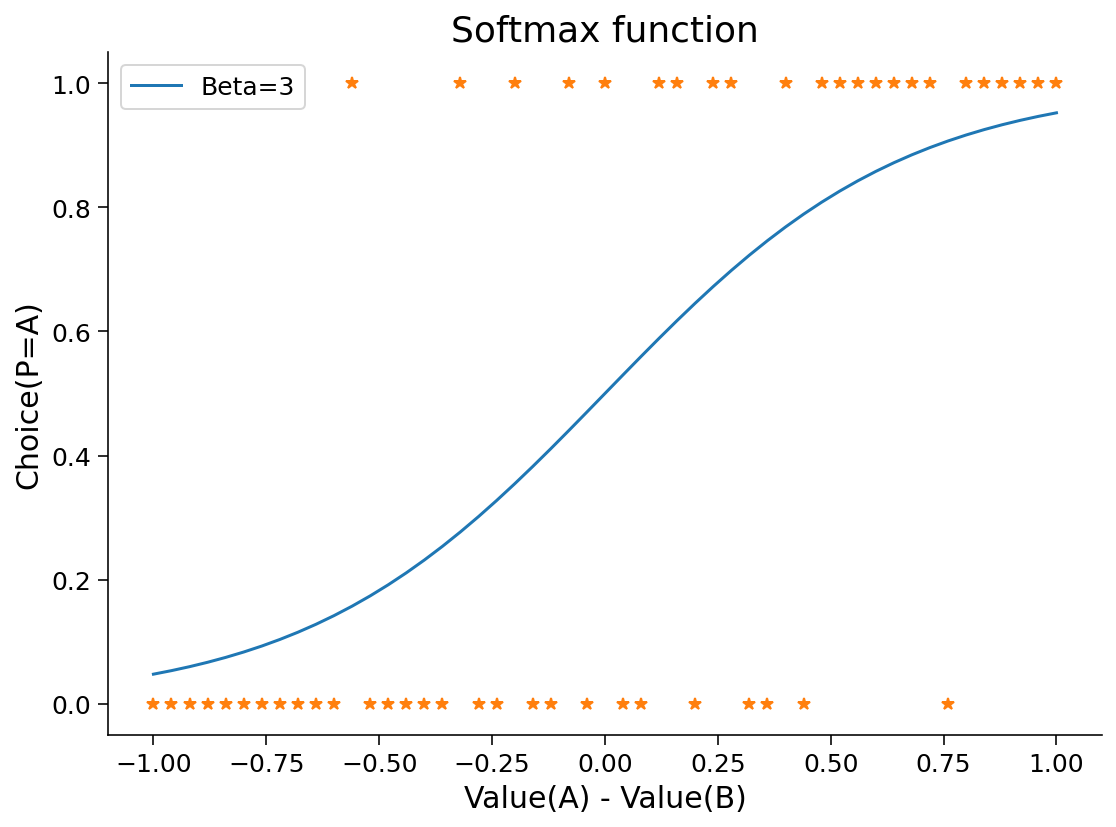

In [ ]:
#@title plot softmax function

pa, data, x_axis = softmax()
beta=3
fig, ax = plt.subplots()
ax.plot(x_axis,pa,label="Beta="+str(beta))
ax.plot(x_axis,data,marker='*',linestyle = 'None')

ax.set_title('Softmax function')
ax.set_ylabel('Choice(P=A)')
ax.set_xlabel('Value(A) - Value(B)')
ax.legend()

* The probability of choosing stimulus A increases monotonically with the difference in value for A versus B.
* The asterisks mark choices that the subject made based on these choice probabilities, and you can see that the subject chooses A most of the time when VA > vBB, but not always.
* This is where the term 'softmax' comes from: the subject picks the stimulus with the maximum value most of the time, so it's a 'soft' maximising function

How does the softmax function change when we change the value of β? Explore the widget below to find out.

In [ ]:
#@title Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_softmax_int(beta = widgets.IntSlider(value=3, min=-100, max=100 , step=1, description="Beta")):
  pa, data, x_axis = softmax(beta)
  fig, ax = plt.subplots()
  ax.plot(x_axis,pa,label="Beta="+str(beta))
  ax.plot(x_axis,data,marker='*',linestyle = 'None')

  ax.set_title('The effect of different values of β')
  ax.set_ylabel('Choice(P=A)')
  ax.set_xlabel('Value(A) - Value(B)')
  ax.legend()

interactive(children=(IntSlider(value=3, description='Beta', min=-100), Output()), _dom_classes=('widget-inter…

* A larger β means that choices become more 'deterministic', i.e. you are more likely to pick the option with the highest value.
* When β is smaller, you become more 'exploratory', i.e. you are more likely to pick the other option now and again as well.

A few optional questions to pique your interest:

* What happens when the value of the softmax β is 0?
 What if β is infinite?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section1_q1.py)

* Can you work out why a negative value for β doesn't make sense?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section1_q2.py)

---
# 2. Data plotting

First, let's have a look at your data! 
In the code snippet below, change "subj" to the subject number you were assigned.



In [ ]:
subj = 20 # change your subject number
simulate = False
fitData = False
plotIndividual = True

url = 'https://raw.githubusercontent.com/rskool/reversal_learning_tutorial/main/participant_data/Reversal_Learning_task_'+str(subj)+'.csv'
data = pd.read_csv(url)

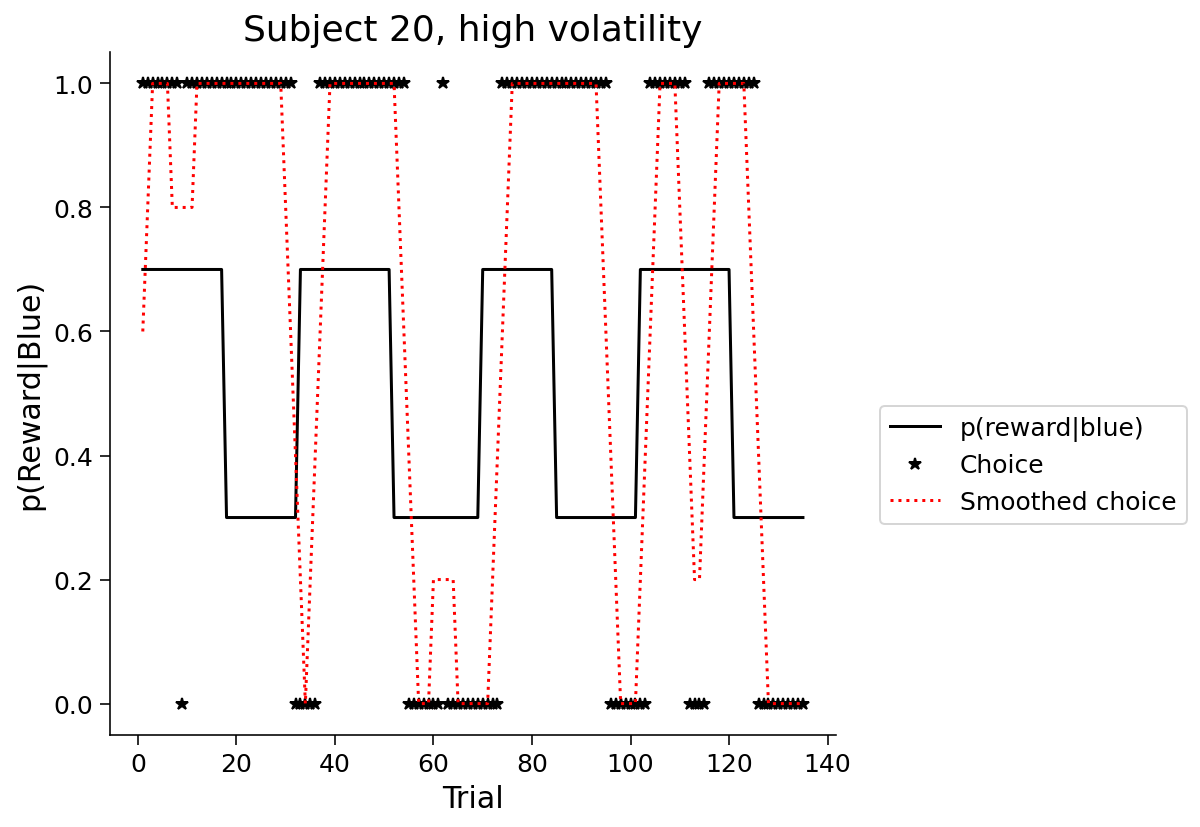

In [ ]:
# @title Run to plot your data
subjData = prepSubDict(subj,data)
revlPlotData(subj,subjData)


- The solid black line is the 'true' probability of being rewarded for blue. This is specified by the experimenter, and determines the feedback you observed.
  - There were periods where the Blue stimulus was rewarded with a 70% probability
  - There were also periods where the Blue stimulus was rewarded with only 30% probability, so then it would be better to pick Orange

- The black asterisks indicate your actual choices, where 1 = blue and 0 = orange.
- The dashed red line is a 5 trial moving average.

---
# 3. Simulating data

We often think about modelling in terms of fitting a model to a participant's behaviour.

However, we can also use the model to simulate what an 'ideal' participant would do, given certain values of the parameters such as learning rate.

This can help us get an intuitive understanding of:

- how these parameters may describe behaviour
- what sort of behaviour our model may capture

Therefore, before we are going to fit the behavioural data, we will first actually generate or simulate some data. This means that we will use our model, which is simply the 2 equations you saw earlier in this tutorial, to 'play' the slot machine game.

__The equations__

The codes implement the update and observation equations.

Check the code cel below.
- Can you find the observation (softmax) equation?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q1.py)

- Can you find the update (Rescorla-Wagner) equation?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q2.py)

In [ ]:
# @title simulation code
def revlSimData(s, simPars, initBlue=0.5, initOra=0.5):
  v = np.array([initBlue, initOra])
  nTrials = 135
  VV = np.empty((0,2),int)
  PP = np.empty((0,2),int)
  choice = np.empty((0,1),int)

  outcomes = genFb(s)
  score = 0

  for i in range(nTrials):
    # Compute likelihood of the each choice option 
      ev  = np.exp(simPars['beta']*v) # exponentiate the value
      sev = np.sum(ev)		            # compute the sum of the values
      p   = ev/sev 		                # probability each choice i.e. ratio of each of the values and their sum. 
    # This code effectively does: 
    # p[0] = ev[0]/sev;
    # p[1] = ev[1]/sev;
      
      
    # Do a weighted coinflip to make a choice: choose stim 1 if random
    # number is in the [0 p[1]] interval, and 2 otherwise
      if np.random.rand(1)<p[0]:
          c = np.array([0])
      else:
          c = np.array([1])
      
      r = outcomes[i,c] # select the outcome for this choice
      
    # update the log likelihood with the p(choice|model):
    # note that this line can be done more efficiently after the trial
    # loop, see below
    
    # store value of V and choice probability
      VV = np.row_stack([VV,v]) # store value of V
      PP = np.row_stack([PP,p])
      
    # update values
      dv  = r-v[c] # compute prediction error
      v[c]= v[c] + simPars['alpha']*dv    # update value
      choice = np.row_stack([choice,c==0])
      score = score + r

  outcome = np.zeros((nTrials,1),'double')
  c=choice.flatten()
  outcome[c==0,0] = outcomes[c==0,0]
  outcome[c==1,0] = outcomes[c==1,1]
  simData = {'choice': choice, 'VV': VV,'PP': PP,'score': score, 'outcome':outcome}

  return simData

# Run the simulation!

Now you are ready to simulate some data.

In the code cell below, make sure you set these parameters as follows:


```
subj = np.array([1,2])
simPars = {'alpha': 0.25, 'beta': 4}

```

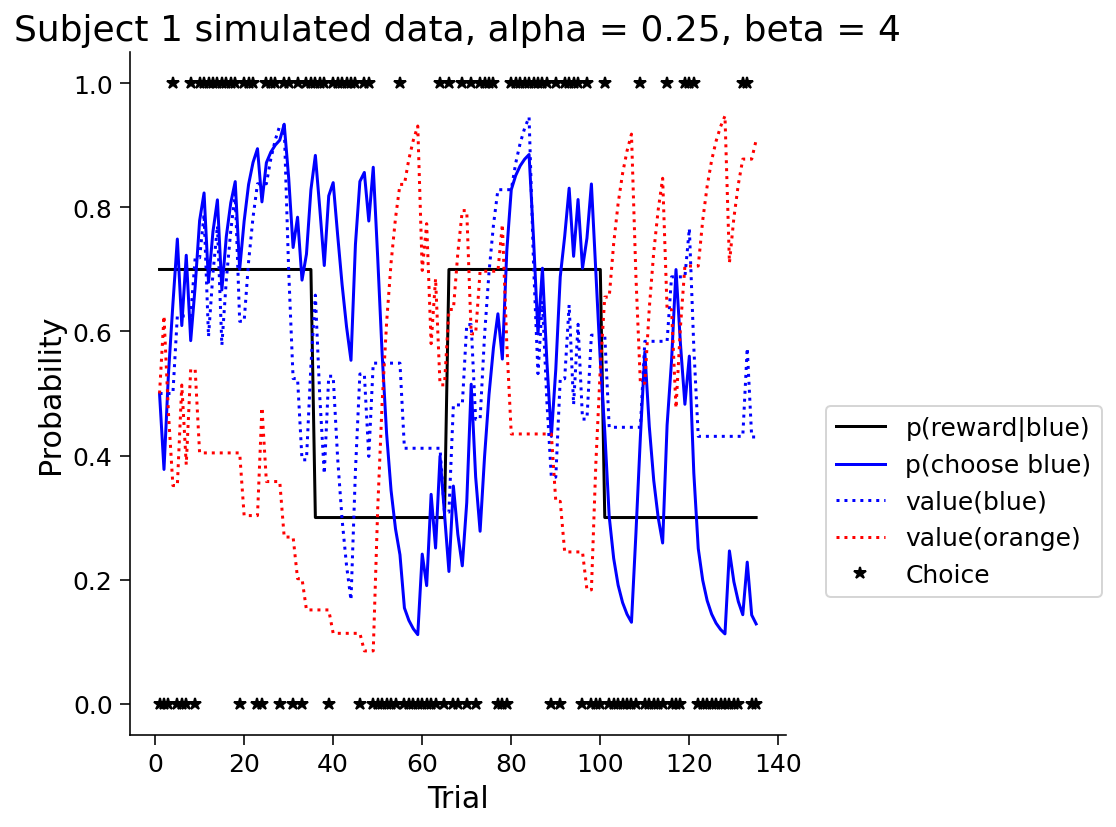

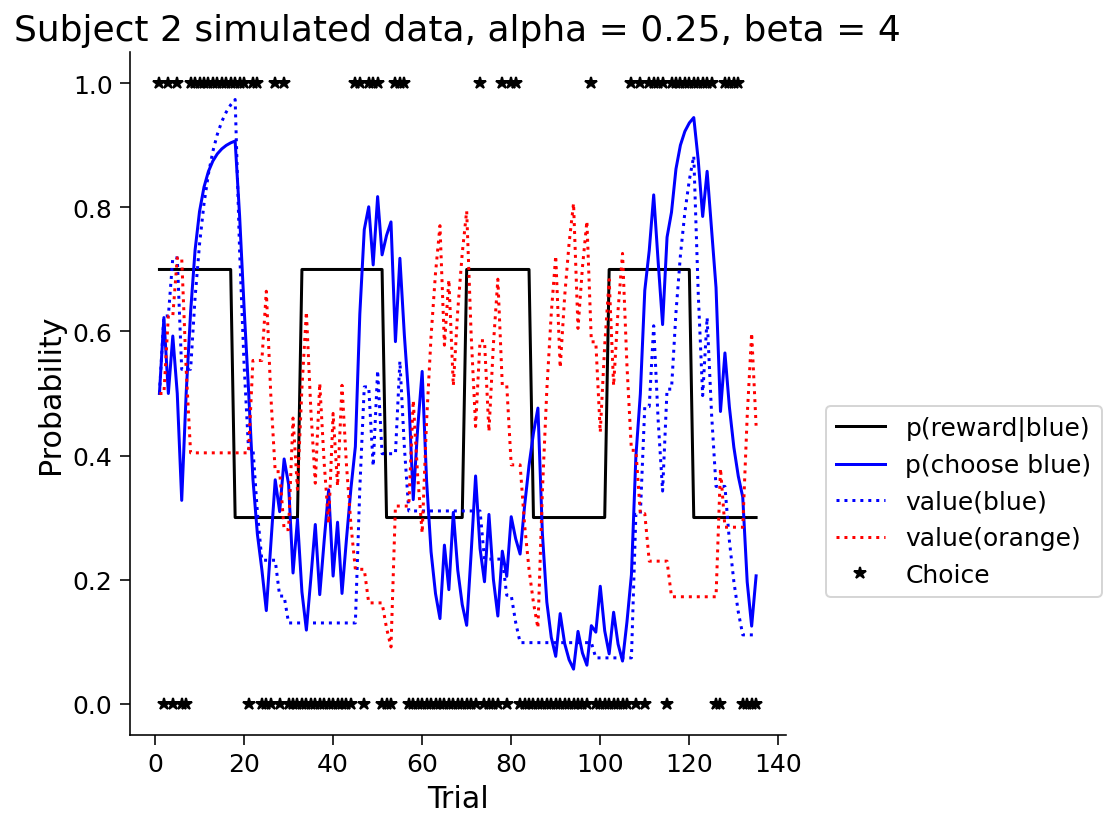

In [ ]:
# @title Run the simulation for example participants!

### edit these lines yourself
subj = np.array([1,2])
simPars = {'alpha': 0.25, 'beta': 4} 
###

for s in subj:
  simData = revlSimData(s, simPars)
  revlPlotSimSingle(s, simData, simPars)

You have just simulated data for 2 subjects, using a learning rate of 0.25 and a beta of 4.

The true reversal rate in the environment was different for the two subjects. This is actually determined by the subject number (it was for you, too!)

- Odd numbered subjects did a low-volatility version of the task with reversals approximately every 20 trials
- Even numbered subjects did a low-volatility version of the task with reversals approximately every 25-30 trials

Both figures show:

- The true underlying probabilities (black line) and simulated choices (black asterisks).
- The values of each of the slot machines (orange and blue dashed lines) that the model learnt based on the feedback it received for each choice.
- The choice probability based on these values (using the softmax function).

You can see that some of the time, the choice doesn't follow the maximum choice probability because of some randomness in the choices due to the softmax function (where some of the time you pick the suboptimal option.

To get rid of some of this noise, we can also have a look at what the simulated data looks like when we average over a large number of subjects, and how well the model performs in this task when we change the learning rates and softmax.

# Lots of participants

To see how the model performs on average, let's run 100 simulated subjects per condition.

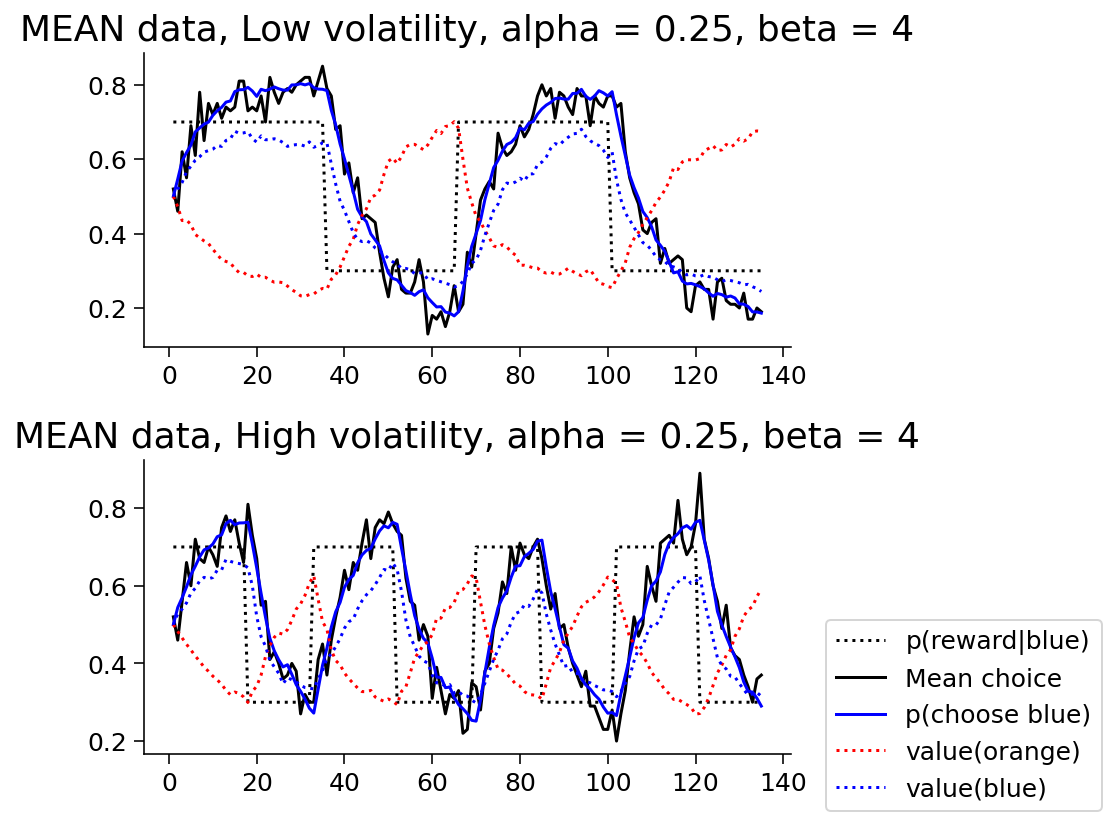

In [ ]:
# @title Run the simulation for many participants!

### edit these lines yourself
subj = np.arange(1,201,1)
simPars = {'alpha': 0.25, 'beta': 4}  
###

valBlueAll = np.zeros((135,0), int)
valOrangeAll = np.zeros((135,0), int)
PPall = np.zeros((135,0), int)
choiceAll = np.zeros((135,0), int)
scoreAll = np.zeros((1,0), int)

for s in subj:
  simData = revlSimData(s, simPars)
  choiceAll = np.column_stack([choiceAll,simData['choice']])
  PPall = np.column_stack([PPall,simData['PP'][:,0]])
  valBlueAll = np.column_stack([valBlueAll,simData['VV'][:,0]])
  valOrangeAll = np.column_stack([valOrangeAll,simData['VV'][:,1]])
  scoreAll = np.column_stack([scoreAll,simData['score']])

simDataAll = {'choice': choiceAll, 'Vblue': valBlueAll, 'Vorange': valOrangeAll,'PP': PPall, 'score': scoreAll}
revlPlotMean(subj,simDataAll, simPars)

*Simulated data for 100 subjects per condition. Top: high volatility, Bottom: low volatility. True probability of getting reward for chosing blue (dashed black); average probability of chosing the blue stimulus (solid blue), based on the value of each stimulus (dashed blue and orange); mean simulated choice (solid black), i.e. for each trial, the mean of a binomial vector of 100 choices, where each entry reflects the choice of that simulated subject on that trial (either 0 or 1). Note that as you increase the number of simulated subjects, the solid black line will start to match the blue line more and more.*

Do you think the model is doing better in one of the two conditions? From these plots, you cannot see individual performance. Therefore, let's next look at the proportion of correct responses, defined as picking blue when blue was more likely to be rewarded, and picking orange in the blocks that orange was rewarded more often:

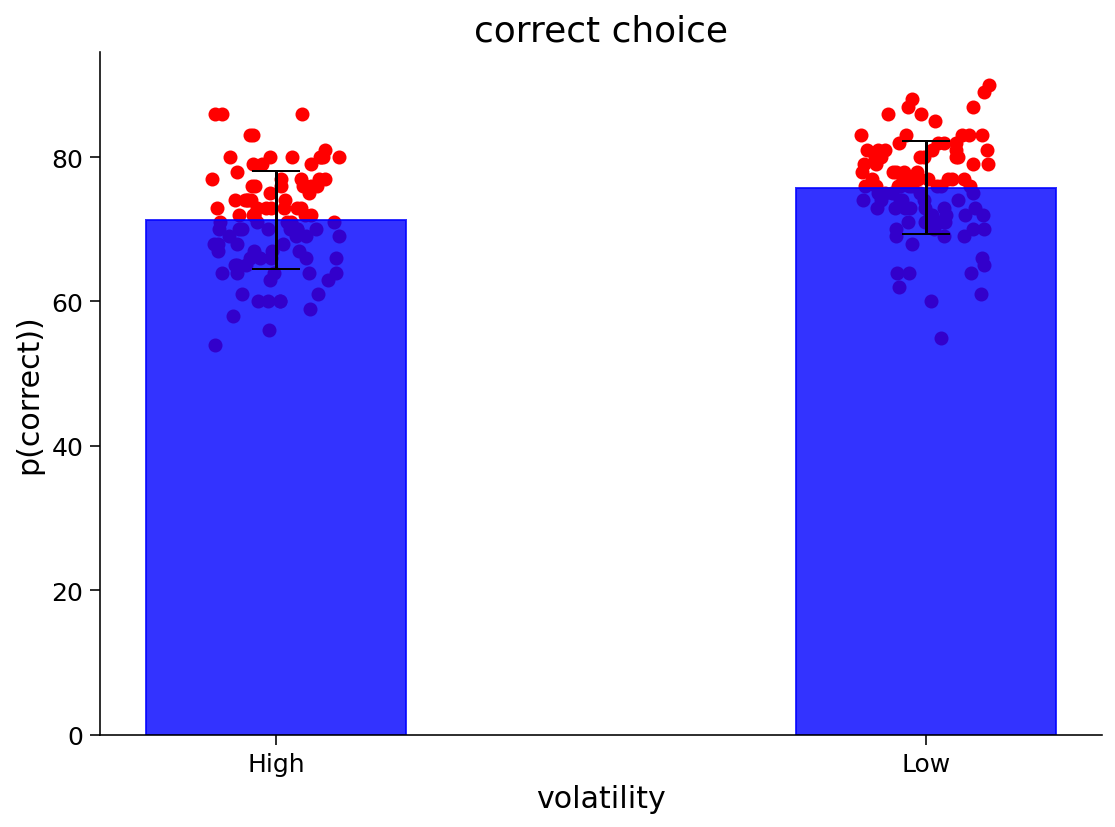

In [ ]:
plotMeanScore(subj,simDataAll)

*Proportion correct for each simulated 'subject' (red circles); average proportion correct for each condition(blue) ± standard deviation (black).*

The model appears to be performing less well in the high volatility condition. Could you think why that is?

# Changing parameter values

Now we can get an intuitive understanding of the learning rate parameter α and the softmax parameter β by changing their values, and seeing how the simulated subject behaves.

In the widget below, set the α and β parameters to a different value...

Try this for a range of different parameter values.
What can you conclude about the effects of α and β?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q3.py)

In [ ]:
# @title run this widget!

@widgets.interact
def plot_sim_alphabeta(alpha = widgets.FloatSlider(value=.25, min=0, max=1 , step=0.05, description="Alpha"),
                       beta = widgets.IntSlider(value=4, min=1, max=100 , step=1, description="Beta")):
  
  subj = np.arange(1,101) 
  simPars = {'alpha': alpha, 'beta': beta} 

  valBlueAll = np.zeros((135,0), int)
  valOrangeAll = np.zeros((135,0), int)
  PPall = np.zeros((135,0), int)
  choiceAll = np.zeros((135,0), int)
  scoreAll = np.zeros((1,0), int)

  for s in subj:
    simData = revlSimData(s, simPars)
    choiceAll = np.column_stack([choiceAll,simData['choice']])
    PPall = np.column_stack([PPall,simData['PP'][:,0]])
    valBlueAll = np.column_stack([valBlueAll,simData['VV'][:,0]])
    valOrangeAll = np.column_stack([valOrangeAll,simData['VV'][:,1]])
    scoreAll = np.column_stack([scoreAll,simData['score']])

  simDataAll = {'choice': choiceAll, 'Vblue': valBlueAll, 'Vorange': valOrangeAll,'PP': PPall, 'score': scoreAll}
  revlPlotMean(subj,simDataAll, simPars)  

interactive(children=(FloatSlider(value=0.25, description='Alpha', max=1.0, step=0.05), IntSlider(value=4, des…

## Optional: Initial values

We have looked at the effect of the parameters, but one of the assumptions that we haven't talked about yet, is the effect of the initial value that the stimuli have:

- On the very first trial, what do we expect to get when we pick a particular stimulus?

So far, we assumed that the subject doesn't have an initial preference, so the initial value is 0.5 for each stimulus.

But, perhaps you are Dutch and have a particular faith in orange.

Or your next door neighbour told you that the blue slotmachine is really good.

In that case, you might start out believing that one stimulus is better than the other. If you would like to play with this option, then try out the widget below, where you can set different initial values for each stimulus.

What do you conclude about the effect of the initial values?

In [ ]:
# @title play with initial values

@widgets.interact
def plot_sim_alphabeta(initBlue = widgets.FloatSlider(value=.5, min=0, max=1 , step=0.05, description="Init Blue"),
                       initOra = widgets.FloatSlider(value=.5, min=0, max=1 , step=0.05, description="Init Orange")):
  
  subj = np.arange(1,101) 
  simPars = {'alpha': 0.25, 'beta': 4} 

  valBlueAll = np.zeros((135,0), int)
  valOrangeAll = np.zeros((135,0), int)
  PPall = np.zeros((135,0), int)
  choiceAll = np.zeros((135,0), int)
  scoreAll = np.zeros((1,0), int)

  for s in subj:
    simData = revlSimData(s, simPars, initBlue, initOra)
    choiceAll = np.column_stack([choiceAll,simData['choice']])
    PPall = np.column_stack([PPall,simData['PP'][:,0]])
    valBlueAll = np.column_stack([valBlueAll,simData['VV'][:,0]])
    valOrangeAll = np.column_stack([valOrangeAll,simData['VV'][:,1]])
    scoreAll = np.column_stack([scoreAll,simData['score']])

  simDataAll = {'choice': choiceAll, 'Vblue': valBlueAll, 'Vorange': valOrangeAll,'PP': PPall, 'score': scoreAll}
  revlPlotMean(subj,simDataAll, simPars)  

interactive(children=(FloatSlider(value=0.5, description='Init Blue', max=1.0, step=0.05), FloatSlider(value=0…

# Fitting simulated data using a grid search
So - we have a model. What does it mean to 'fit' the model to data?

- We need to determine the values of the parameters, α and β, that make the model behave as similarly to the real participant as possible.

As a 'sanity check', we will first fit the model to the simulated data,i.e. estimate the parameter values from the observed choices, to see how well we can 'recover' the parameters we put in.

- For the simulated data, we know the values of the parameters α and β
 - In the simulated data, α and β are parameters we set ourselves
 - In real subjects' data, α and β are unknown

__Grid search__

There are various ways you could determine the best-fitting values of α and β.

We are going to use a __grid search__, which means:

- We run the model with a whole range of values of α and β
- For each pair α,β we work out how well the model predicts the data
 - This is defined as the likelihood of the parameters given the observed data
- We can plot the outcome as a colourful grid!

## Optional: Mechanics of the grid search

The aim of the grid search is to find the values of the parameters that maximise the probability of the observed data, given the model that we are fitting.

Let's make that a little bit less abstract. Suppose we have 3 trials. On every trial, the subjects can pick orange or blue.

That means we have the following potential choice sequences:

[BBB]; [BBO]; [BOB]; [BOO]; [OBB]; [OBO]; [OOB]; [OOO]

- For each trial there are 2 options, so there are 2^3 = 8 possible sequences of three outcomes.
- This means that for chance behaviour each combination has a probability of occurring of 1/8.
- This is the probability for a 'chance' model.

\begin{equation}
p(data| chance) = (1/2)^n
\end{equation}

What we want of course is that our model that predicts the sequence of choices in our data at above chance level.

Using the update and observation equations, we can predict the probability that the subject chooses Orange (or Blue) given the Value of Orange and Blue, and the parameters alpha and beta, on each trial.

For a sequence of choices, we get a sequence of single-trial probabilities for choosing Orange (or Blue), which are multiplied together to give a probability for the whole sequence:

\begin{equation}
p(data| m) = p_{c,t1} \cdot p_{c,t2} \cdot p_{c,t3} ... p_{c,tn}
\end{equation}

This quantity p(data|model) is also known as the likelihood of the data.

Now we need to determine the parameter values that maximise the likelihood of the data.

We will use a very simple approach, called a grid search. The advantage of a grid search is that it's conceptually easy and easy to implement, but it's computationally expensive, particularly if you have many parameters. Luckily for us, we only have 2.

To do a grid search of the parameter space, we define a range of parameter values for each parameter, and compute for values within this range the probability of the observed responses. Then we check which set of values explains the data best, and declare that the winner.

So first we need to decide what range of parameter values we want to use. Can you think of something sensible, based on the playing around with the simulations that you've done above?

[*Click for solution*]((https://github.com/reneek/reversal_learning_tutorial/answers/section3_q4.py)

# Running the grid search

__Note about using the grid search approach__

The grid search approach is conceptually simple, easy to implement, and results are easy to visualise . However, with models with a larger number of parameters, the computational time and memory quickly explode, even for relatively coarse bins. In addition, you might want to constraint your parameters in other, more complex ways. For example, you might want to constrain your parameters using informative priors (other than the hard bounds we've used here), or even use 'empirical' priors in a hierarchical mixed model approach. Or you might want to use a sampling approach, such as MCMC. Details about these other approaches goes beyond the scope of this tutorial. Rather, we hope that an understanding the basic grid search will provide you with a firm grounding to explore these other options by yourself.

__Running a grid search__

So we will leave these complexities for now and set up the grid search below:

[0.45]
[3.]


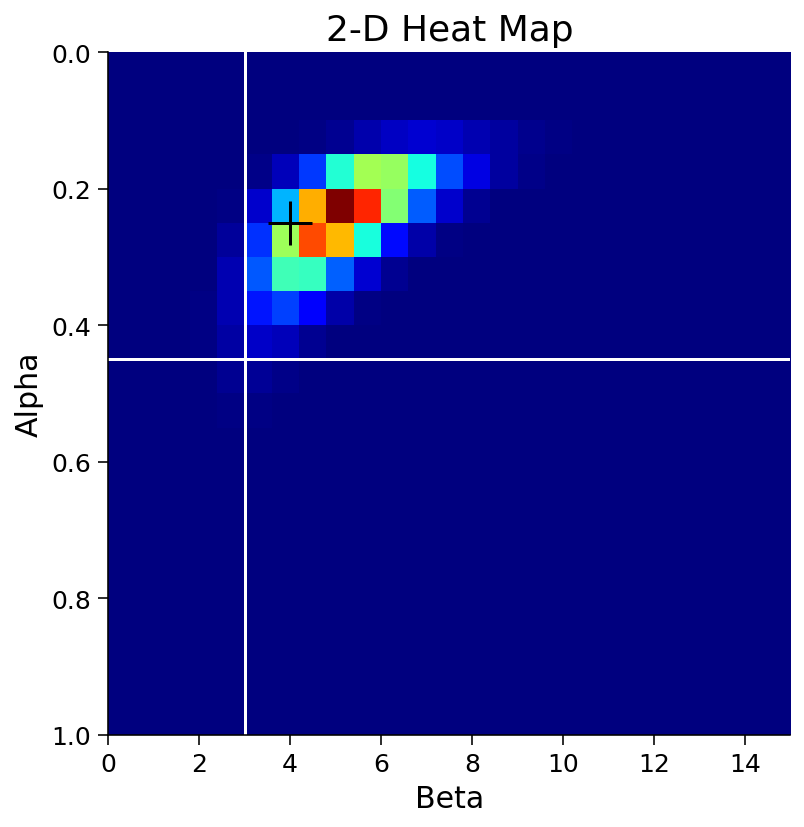

In [ ]:
# grid search

subj =np.array([1])
simPars = {'alpha': 0.25, 'beta': 4}
simData = revlSimData(subj, simPars) # simulate data for one subject

fitSettings = {'bounds': [[0.05,1.05],[0.6,15.6]], 'nBin':[20, 25]}

lik = runGridSearch(simData,fitSettings)
plotGridSearch(lik,fitSettings)

This gives you a plot of the likelihood for all of the bins in a 2D plot.

*Black cross: true parameter values used to generate the data.*

*White crosshairs: maximum likelihood (the peak or mode of the distribution)*

This plot is a 2-dimensional heatmap that indicates the probability of the data given the model, with hotter colours meaning higher likelihood

- Along the x-axis, we are varying β whilst keeping α constant
- Along the y-axis, we are varying α whilst keeping β constant
- If we had had 3 parameters in our model, this would become a 3D plot (and much harder to visualise!).
Is there anything that you notice in this plot?


[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q5.py)

# Marginal distributions for α and β

Most of the time we will be interested in the value of each parameter, not in this full 2D 'likelihood landscape'.

In order to achieve this, we can for each parameter, or dimension, 'collapse' or 'marginalise' this plot over the other dimensions.

What do you think the marginal distributions for α and β look like?


In [ ]:
# @title plot marginal distributions

plotMarg(lik,fitSettings)

TypeError: ignored

- To get the parameter distribution for α, we sum the 2D likelihood plot along the vertical dimension.
- To get the parameter distribution for β, we sum the 2D likelihood plot along the horizontal dimension.

## Summary values for α and β

The distributions over α and β give us a full picture of these parameters: a probability for each value in the bin, that that parameter value generated the observed data.

However, for our analysis we usually we want a single estimate for α and β.

How would you go about obtaining this from the distributions plotted on the previous page?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q6.py)

Let's have a look at how well this model is performing. In the original trial-by-trial dataplot, we now added the estimated choice probabilities (in turquoise)

In [ ]:
# @title simulate-refit results: trial-by-trial choice probabilities

subj =np.array([1])
simPars = {'alpha': 0.25, 'beta': 4}
simData['pfit'] = pp

revlPlotSimSingle(subj, simData, simPars,plotFit=True)

*Overall, the estimated choice probabilities in green are matching the original, simulated choice probabilities (in blue) very well. You could also add the estimated values of each of the stimuli here and compare how they match the simulated values.*

From this plot, it is hard to quantify how well the estimated probabilities are matching the simulated choice probabilities. We will next look at the correlation of the original, simulated choice probabilities, and correlate these with the choice probabilities that we obtained from both the maximuml likelihood and expected value estimates:

In [ ]:
# @title simulate-refit results: choice probability correlogram

## TODO plot scatter, maximum liklehood and expected value


*Correlation of simulated probability of choosing blue with 1) maximum likelihood estimate (ML; blue) and 2) expected value estimate (EV; red) of the choice probabilities For perfect performance, the estimated and true probabilities are identical, ie on the unity line (black dashed). Both ML and EV estimates are doing very well, though in this single simulation/refit it looks like the EV estimate is performing slightly better than the ML.*

- The solid black line is the 'true' probability of being rewarded for blue. This is specified by the experimenter, and determines the feedback you observed.
 - There were periods where the Blue stimulus was rewarded with a 70% probability
 - There were also periods where the Blue stimulus was rewarded with only 30% probability, so then it would be better to pick Orange
- The black asterisks indicate the subject's actual choices, where 1 =blue and 0 =orange.
- The dashed red line is a 6 trial moving average.

To quantify whether the ML or EV is doing better, you would have to run many simulations for a range of parameter values, and compare how much the ML and EV predicted choice probabilities deviate from the simulated choice probabilities.

Below, we will do something slightly different, and have a look at how good both the ML and the EV estimates, are at recovering parameter values for α and β across a large number of iterations.

Because estimating the parameters takes a bit longer than just generating data, we'll go for a slightly lower subject number, let's do 20 for each of the 2 conditions.

If you run the cell below, you should see both the probability density functions (PDFs) for each of the parameter across all subjects, separately for each condition.

In [ ]:
# @title Probability distributions for each subject and each parameter.

subj = np.arange(1,41) 
simPars = {'alpha': 0.25, 'beta': 4}  

fitSettings = {'bounds': [[0.05,1.05],[0.6,15.6]], 'nBin':[20, 25]}

alphalik = np.zeros((0,fitSettings['nBin'][0]), int)
betalik = np.zeros((0,fitSettings['nBin'][1]), int)
alphamax = np.zeros((0,1), int)
betamax = np.zeros((0,1), int)

# simulate data for 40 subjects and gather values we need now and later
for s in subj:
    simData = revlSimData(s, simPars)
    lik = runGridSearch(simData,fitSettings) 
    marglik = calcMarglik(lik)
    estAlpha, estBeta = getParamEst(lik)
    
    alphalik = np.row_stack([alphalik,marglik[:,1]])
    betalik = np.row_stack([betalik,marglik[:,0]])
    alphamax = np.row_stack([alphamax,estAlpha])
    betamax = np.row_stack([betamax,estBeta])
    
    ## TODO expected value

plotMargGroup(subj,alphalik,betalik,simPars,fitSettings)

*Each coloured line is an individual subject*

*Dashed vertical line indicates the parameter value used to simulate the data*

- If the distributions are 'peaked', then we have high confidence in the estimate of the parameters
- If the distributions are very broad, our estimates are less precise
- Note that for some subjects, the tails of the distributions are cut off, or 'hit the bounds' of our grid. This might mean that you have to enlarge the grid to cover the full parameter space.
- Remember the true values of α and β (the ones we put into the simulation) are 0.25 and 4.
 - How well is the model doing at recovering these parameter values?
    
Run the next cell to view the estimated paramaters aggregated across all subjects:

In [ ]:
# @title Summary of parameter values for 20 subjects/condition

# expected value and max likelihood
plotSumPar(subj, alphamax, betamax,alphaex,betaex)

*LEFT: maximum likelihood estimate (distribution peak), RIGHT: expected value (distribution mean). Mean across simulations (blue) ± standard deviation (grey); individual estimates from each simulation (red); 'ground truth' (green) - i.e. the parameter values used to simulate the data.*
        
What conclusions can we draw from these plots?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section3_q7.py)

---
# 4. Fitting real data using a grid search

Finally, we can start to plot the data we collected from real participants!

## Individual data: you!

First, let's estimate the learning model for your own data. In the cell below, change subj to your subject number and run the cell.

This will show you 3 types of plots:

1. Trial-wise plot that you saw earlier plotting your own choices and the true underlying probability of reward for the blue slot-machine (p(reward|blue)), the running-average choices (dashed red line), and now in green the estimated probability of choosing blue (p(choose blue).
Does the estimated choice probability follow your choices reasonably well?
2. Likelihood surface plot. Is the surface plot nicely peaked? Or is there a lot of structure in the plot that might indicate a correlation between parameter values?
3. Marginal parameter distributions. Are the distributions relatively normal, or very skewed? Are they peaked (ie do you have high confidence in a single value) or very broad . Are the distributions cut off at the bounds? That might indicate you need to relax the bounds a little.

In [ ]:
# @title fit your own data!

subj = 1 # change to your subject number
url = 'https://raw.githubusercontent.com/rskool/reversal_learning_tutorial/main/participant_data/Reversal_Learning_task_'+str(subj)+'.csv'
data = pd.read_csv(url)

simData = prepSubDict(subj,data)

fitSettings = {'bounds': [[0.05,1.05],[0.6,15.6]], 'nBin':[20, 25]}

# run grid search
lik = runGridSearch(simData,fitSettings) 

# plot grid search
plotGridSearch(lik)

# get probability model for estimated parameters
estAlpha,estBeta = getParamEst(lik)
simPars = {'alpha':estAlpha, 'beta':estBeta}
logl, pp = revlFitData(simData, simPars)
simData['pfit'] = pp

# trial-wise plot
revlPlotData(subj, simData,plotFit=True)

# marginal parameter distributions
## TODO plotMarg(lik) 
plotMarg(lik)

## Group data

We'll next do the analysis across all the data. First, let's have a look at what the group data actually looks like, when averaged across a pool of real participants. Run the cell below.

In [ ]:
subj = np.arange(1,6,1) # change according to the number of participants that completed the task/their indices

groupData = {'s': subj}

PPall = np.zeros((135,0), int)
choiceAll = np.zeros((135,0), int)
outcomeAll = np.zeros((135,0), int)
scoreAll = np.zeros((1,0), int)


# load in data
for s in subj:
    url = 'https://raw.githubusercontent.com/rskool/reversal_learning_tutorial/main/participant_data/Reversal_Learning_task_'+str(s)+'.csv'
    data = pd.read_csv(url)
    subjData = prepSubDict(subj,data)
    choiceAll = np.column_stack([choiceAll,subjData['choice']])
    outcomeAll = np.column_stack([outcomeAll,subjData['outcome']])
    
subjDataAll = {'choice': choiceAll,'outcome': outcomeAll}
revlPlotAll(subj,subjDataAll)

This plot does shows you the observed average choice across participants for each trial (which is why there are no error bars!).
You also get a bar plot with the average proportion of correct choices for both the high and low volatile groups.

- Does it look like one of the two groups is better than the other?
- How does this compare to the simulated data? Can you think of why these might differ?

Next we will fit the model to all of the available data. First, we'll look at the full probability distributions for each of the parameters for each participant.

In [ ]:
# @title Parameter estimates for α and β - distributions

fitSettings = {'bounds': [[0.05,1.05],[0.6,15.6]], 'nBin':[20, 25]}

c=0
for s in subj:
    subjData = {'choice': choiceAll[:,c], 'outcome': outcomeAll[:,c]}
    lik = runGridSearch(subjData,fitSettings)
    
    c=c+1
    # compute max lik parameter estimates
    # save in an array

# plot for even and uneven subjects parameter estimates

*Each coloured line is one individual subject. Note that the subjects plotted in the high vs. low volatility conditions are not the same individuals*

- These probability distributions give us a sense of how confident we are in the estimated value for each subject and parameter. For some of the subjects the tails of the distributions are cut off. This might mean that you need to expand your bounds, particularly if there is no theoretical reason to not expand them.
- For example, α is usually constrained to [0 1] which ranges from no learning to full updating of your belief based on only the last trial. For β, we discussed the bounds previously: while there is a theoretical lower bound of 0 (=random choice), there is no upper bound (remember beta = inf meant completely deterministic behaviour), so we could easily expand this bound when estimating the parameters

When looking at the full plot of all of the subjects, do you think that the parameter estimates are very different for the high and low volatility groups? Or perhaps you find these plots a little hard to read?

Indeed, because these parameter density plots are a little hard to read, we can also summarise these parameter estimates (based on the maximum likelihood and expected value) across subjects:

In [ ]:
# @title Parameter estimates for α and β - summary

# plot max lik and est for alpha and beta

*Average estimated choice probabilities(blue) +/- standard deviation(grey), and individual datapoints(red)*

*LEFT:'maximum likelihood' based estimates, i.e. the peak of the distributions in the figure above.*
    
*RIGHT: 'expected value' based estimates, i.e. the means of the distributions in the figure above. Using the mean can result in more robust parameter estimates.*

Do you notice any marked differences between the EV and ML estimates?

[*Click for solution*](https://github.com/reneek/reversal_learning_tutorial/answers/section4_q1.py)

Finally, let's have a look at how the average choice probability compares to the average choices.

In [ ]:
# @title Estimated choice probabilities

#mean plot per condition with pp as a jacknife

*Average estimated choice probabilities +/- standard deviation.*

The average estimated choice probabilities across subjects for each of the conditions follow the average group choice well. Note that this is a slightly strange representation as for each individual, the choice data is a binomial vector of [0 1] choices, while the estimated p(choice) vector can take on any value between [0 1]. This is therefore not a plot to do statistics on, but rather to get a global idea of how well your model is doing.

In the next section, we will have a very brief look on how you would do inference on these parameters.

## Statistical inference on the model parameters
Let's end with a little bit of science and ask the question:

 - Do subjects adapt their learning rate or softmax decision parameter based on whether they are in a volatile or stable environment?

For this, we can simply use a python stats library, using a 2-sample t test or (if the parameters are not normally distributed) a Mann-Whitney U test

We will use the output of the previous step.

For the sake of time we will not go over doing normality tests of the data, which you should normally do, but just run both the parametric and nonparametric statistics and see whether they are consistent (keeping in mind that the nonparametric stats is more stringent)

In [ ]:
# @title Run some stats

# stats on something

print(['parametric p-value for significant difference in posterior expected values for the learning rate alpha:'+ str(x) +', and softmax temperature beta:'+str(y)])
print(['nonparametric p-value for significant difference in posterior expected values for the learning rate alpha:'+ str(x) +', and softmax temperature beta:'+str(y)])


__Note on the scope of this tutorial__

The aim of this tutorial is to give you an introduction on the basics of using reinforcement learning models to understand behaviour: what the most basic model looks like mathematically; how to specify this model in python; run simulations; estimate parameters; and visualise results. This section on inference on model parameters is purposefully only very brief. You can use the estimated parameter in the same way you would use any summary statistic of your data, and analyse them in your favourite statistical package (R, SPSS, SAS) and statistical framework (frequentist, Bayesian).

---
# 5. Review

## A very brief recipe for modelling your data
To finish this section, below is a very brief overview of the steps you would want to take when trying a modeling approach to your data.

This is by no means exhaustive nor a set of hard rules, and definitely doesn't replace you having to use your own brain, but we hope it will give you a good basis to start from.

1. Define your model: this is your quantitative hypothesis of how your subjects do your task.

2. Do a generative model check, a.k.a. Does your model do what it's supposed to do?:
 2.1 Simulate data using different parameter settings and let the model play your task.
   - Does your model generate the behaviour you (expect to) see in your subjects?
   - If not, it won't be a very good model for your data!
 2.2 See whether your model can recover parameters: plot the correlation of simulated and recovered parameters. These should be closely correlated.
   - If the estimated parameters are wildly off what you put in, you have a problem. You need to reconsider the parameterisation.
   - It's likely that some of the parameters are correlated
 2.3 Optional (more advanced): When you generate data from your model, do other simpler models have higher model evidence? Are they a better model for explaining your data?
   - If this is the case, your model is likely overparameterised,i.e. you have correlations between your parameters or some of your parameters do not capture any variance

3. Fit your data, and see whether the evidence 'landscape' looks like it has a nice peak in it, meaning that you can be relatively confident in your parameter estimates.

4. If you have multiple models (usually you will): do model comparison to see which model is the best and most parsimonious explanation of your data.
    
5. Do inference on the parameters of your model.

In [ ]:
# @title Loading in the data


In [ ]:
# checking which fields exist within the dictionary


# accessing data within the matlab struct using dictionary fielda
print(v['data'][0,0]['tm'][0,0]['stim']);

[[273407.77318296]
 [273409.47627383]
 [273411.24620206]
 [273412.7824533 ]
 [273414.402179  ]
 [273416.37241881]
 [273418.57652547]
 [273420.26302059]
 [273421.83257172]
 [273423.53580297]
 [273425.03855057]
 [273426.67492153]
 [273428.22786935]
 [273429.89761688]
 [273431.48387757]
 [273433.02007055]
 [273434.57292389]
 [273436.17596659]
 [273437.86242881]
 [273439.3819068 ]
 [273441.08507948]
 [273442.5544798 ]
 [273444.15748749]
 [273445.74376267]
 [273447.38028034]
 [273449.06660038]
 [273451.07032693]
 [273452.62324004]
 [273454.07594619]
 [273455.54533081]
 [273457.148292  ]
 [273458.61785593]
 [273460.17059728]
 [273461.67341038]
 [273463.19287569]
 [273464.84597252]
 [273466.36550967]
 [273467.91837176]
 [273469.52133749]
 [273471.10763652]
 [273472.99455462]
 [273474.53061417]
 [273476.20045135]
 [273477.7700224 ]
 [273479.33963693]
 [273480.84242558]
 [273482.49554384]
 [273484.11519346]
 [273485.91875906]
 [273487.4714177 ]
 [273489.09110989]
 [273490.6108985 ]
 [273492.096